# Good thing about NN is output can be hard capped. Without needing to modifying loss during architecture construciton.

In [132]:
import numpy as np
import torch
import torch.nn as nn
import copy
from scipy.stats import qmc


maturity = 24 * 2 # units are in hours
global dt; dt = 15/60;
nstep = int(maturity/dt)
# B and I range
B_min = -6
B_max = 6
I_max = 10
# OU params
alpha = 0.5; m0 = 0; sigma = 2
I0 = 5

t = torch.linspace(0,48,nstep+1)
dt = t[1] - t[0]
N_MC = 2**10


# Set up NN for optimal control
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        # 4-layer NN, 1-dim input layer, 2 hidden layers with 12-dim and 1 output layer with 1-dim
        self.net = nn.Sequential(
            nn.Linear(2,32),
            nn.ELU(),
            nn.Linear(32,32),
            nn.ELU(),
            nn.Linear(32,32),
            nn.ELU(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        out = torch.squeeze(self.net(x))
        ub = torch.minimum(B_max*torch.ones(len(x[:,1])), (I_max-x[:,1])/dt)
        lb = torch.maximum(B_min*torch.ones(len(x[:,1])), (-x[:,1])/dt)
        out = torch.minimum(out,ub)
        out = torch.maximum(out,lb)
        return out
    

In [133]:
# NN for optimal value function corresponding to optimal control
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        # 4-layer NN, 1-dim input layer, 2 hidden layers with 12-dim and 1 output layer with 1-dim
        self.net = nn.Sequential(
            nn.Linear(2,32),
            nn.ELU(),
            nn.Linear(32,32),
            nn.ELU(),
            nn.Linear(32,32),
            nn.ELU(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        out = self.net(x)

        return out

In [135]:
def g(I):
    #return 2*torch.maximum(5-I,torch.zeros(len(I)))
    return 200*torch.maximum(5-I,torch.zeros(len(I)))


def f(X,I,B):
    return (X+B)**2 *dt

In [136]:
def demandSimulate(α, m, σ, n_step, n_sim, maturity, P0):
    
    t = torch.linspace(0,maturity,nstep+1)
    dt = t[1] - t[0]
    priceMatrix = torch.zeros((n_sim, n_step+1))
    priceMatrix[:,0] = P0
    

    dW = torch.normal(0,1,size = (n_sim,n_step) ) * np.sqrt(dt)


    for i in range(1,n_step+1):
        priceMatrix[:,i] = priceMatrix[:,i-1] + α * (m - priceMatrix[:,i-1]) * dt + σ * dW[:,i-1]
        
    return priceMatrix

In [5]:
trained_policy = [None] *nstep
trained_V = [None] *nstep


$S = (X_t, I_t)$

In [162]:
mean = torch.Tensor([0])
std  = torch.sqrt(4*(1- torch.exp(-2*0.5* t[len(t)-1])))
size = torch.Tensor([10])

In [189]:

for i in range(len(t)-1,0,-1):
    # set starting points
    sampler = qmc.Sobol(d=2, scramble=False)
    # 1024 samples : simple space fillling designs
    W = torch.Tensor(sampler.random_base2(m=10))
    X_prev = -5 + 10*W[:,0]; # X0 in [-5,5]
    I_prev = torch.Tensor(10*W[:,1]);# Ic in[0,Imax = 10]
    
    NN = Model1()
    param_list = NN.parameters()
 
    
    # Set up the optimizer (Adam, can also replace with SGD)
    eta = 0.005
    opt = torch.optim.SGD(param_list,lr = eta,weight_decay = 0.0001)
    N_epoch = 1000
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=128, gamma=0.1)
    print(str(t[i])+"training \n")
    print("Training controls: \n")
    for n in range(0,N_epoch):

        X_train = torch.column_stack((X_prev,I_prev))  
        X_next = demandSimulate(alpha, m0, sigma, 1,len(X_prev), maturity, X_prev)[:,1]   
        opt_ctrl = torch.squeeze(NN(X_train))
        I_next = I_prev+opt_ctrl *dt
        if i == len(t)-1:
            next_V = g(I_next)
        else:
            train = torch.column_stack((X_next,I_next))
            next_V =  torch.squeeze(trained_V[i](train))

        total_loss = f(X_prev,I_prev,opt_ctrl) +next_V

        Loss = torch.mean(total_loss) 
        opt.zero_grad()
        Loss.backward()
        opt.step()
        if n%100 == 0:
            print("Epoch: " + str(n))
            print("Loss: " + str(round(Loss.detach().item(),6)))
    
    trained_policy[i-1] = NN

    # NN for optimal V
    ## NN for optimal control
    NN = Model2()
    param_list = NN.parameters()
    print("Training V_hat: \n")
    # Set up the optimizer (Adam, can also replace with SGD)
    eta = 0.005
    opt = torch.optim.Adam(param_list,lr = eta,weight_decay=0.0001)
    N_epoch = 1000
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=128, gamma=0.1) 
    for n in range(0,N_epoch):    

        X_train = torch.column_stack((X_prev,I_prev))  
        X_next = demandSimulate(alpha, m0, sigma, 1,len(X_prev), maturity, X_prev)[:,1]   
        opt_ctrl = torch.squeeze(trained_policy[i-1](X_train))

        I_next = I_prev+opt_ctrl *dt
        if i == len(t)-1:
            true_V = f(X_prev,I_prev,opt_ctrl) + g(I_next)
        else:
            train = torch.column_stack((X_next,I_next))
            true_V = f(X_prev,I_prev,opt_ctrl) + torch.squeeze(trained_V[i](train))

                            
        est_V = torch.squeeze(NN(X_train))


        total_loss = (est_V-true_V)**2
        Loss = torch.mean(total_loss)
        opt.zero_grad()
        Loss.backward()
        opt.step()
        if n%100 == 0:
            print("Epoch: " + str(n))
            print("Loss: " + str(round(Loss.detach().item(),6)))
                          
    trained_V[i-1] = NN

tensor(48.)training 

Training controls: 

Epoch: 0
Loss: 250.337799
Epoch: 100
Loss: 133.016159
Epoch: 200
Loss: 133.016159
Epoch: 300
Loss: 133.016159
Epoch: 400
Loss: 133.016159
Epoch: 500
Loss: 133.016159
Epoch: 600
Loss: 133.016159
Epoch: 700
Loss: 133.016159
Epoch: 800
Loss: 133.016159
Epoch: 900
Loss: 133.016159
Training V_hat: 

Epoch: 0
Loss: 60330.949219
Epoch: 100
Loss: 640.12085
Epoch: 200
Loss: 78.000679
Epoch: 300
Loss: 51.992638
Epoch: 400
Loss: 40.67765
Epoch: 500
Loss: 33.345245
Epoch: 600
Loss: 28.116676
Epoch: 700
Loss: 24.303587
Epoch: 800
Loss: 21.467182
Epoch: 900
Loss: 19.363104
tensor(47.7500)training 

Training controls: 

Epoch: 0
Loss: 135.906693
Epoch: 100
Loss: 59.628231
Epoch: 200
Loss: 59.497993
Epoch: 300
Loss: 59.43454
Epoch: 400
Loss: 59.588146
Epoch: 500
Loss: 59.44463
Epoch: 600
Loss: 59.634731
Epoch: 700
Loss: 59.608551
Epoch: 800
Loss: 59.618202
Epoch: 900
Loss: 59.711044
Training V_hat: 

Epoch: 0
Loss: 13053.291016
Epoch: 100
Loss: 515.281799
Epo

Epoch: 300
Loss: 18.55406
Epoch: 400
Loss: 17.77758
Epoch: 500
Loss: 18.495378
Epoch: 600
Loss: 17.436281
Epoch: 700
Loss: 19.179777
Epoch: 800
Loss: 19.898184
Epoch: 900
Loss: 17.595325
tensor(44.5000)training 

Training controls: 

Epoch: 0
Loss: 24.850895
Epoch: 100
Loss: 23.518574
Epoch: 200
Loss: 23.349266
Epoch: 300
Loss: 23.538553
Epoch: 400
Loss: 23.636183
Epoch: 500
Loss: 23.67918
Epoch: 600
Loss: 23.650208
Epoch: 700
Loss: 23.614315
Epoch: 800
Loss: 23.503109
Epoch: 900
Loss: 23.511484
Training V_hat: 

Epoch: 0
Loss: 692.128235
Epoch: 100
Loss: 22.519533
Epoch: 200
Loss: 22.431852
Epoch: 300
Loss: 19.304192
Epoch: 400
Loss: 16.919762
Epoch: 500
Loss: 18.992493
Epoch: 600
Loss: 21.483446
Epoch: 700
Loss: 19.043909
Epoch: 800
Loss: 19.796442
Epoch: 900
Loss: 19.003853
tensor(44.2500)training 

Training controls: 

Epoch: 0
Loss: 25.266088
Epoch: 100
Loss: 24.020269
Epoch: 200
Loss: 24.177349
Epoch: 300
Loss: 24.01655
Epoch: 400
Loss: 24.416809
Epoch: 500
Loss: 24.163195
Epoch:

Epoch: 900
Loss: 27.225327
Training V_hat: 

Epoch: 0
Loss: 772.488647
Epoch: 100
Loss: 10.094925
Epoch: 200
Loss: 8.190368
Epoch: 300
Loss: 7.357712
Epoch: 400
Loss: 7.317579
Epoch: 500
Loss: 7.580938
Epoch: 600
Loss: 6.872267
Epoch: 700
Loss: 6.362817
Epoch: 800
Loss: 6.886454
Epoch: 900
Loss: 6.941049
tensor(41.)training 

Training controls: 

Epoch: 0
Loss: 29.254589
Epoch: 100
Loss: 27.508415
Epoch: 200
Loss: 27.59923
Epoch: 300
Loss: 27.548344
Epoch: 400
Loss: 27.53162
Epoch: 500
Loss: 27.503088
Epoch: 600
Loss: 27.507954
Epoch: 700
Loss: 27.584972
Epoch: 800
Loss: 27.551622
Epoch: 900
Loss: 27.560339
Training V_hat: 

Epoch: 0
Loss: 802.552429
Epoch: 100
Loss: 9.693153
Epoch: 200
Loss: 7.248277
Epoch: 300
Loss: 5.821341
Epoch: 400
Loss: 7.216234
Epoch: 500
Loss: 7.188941
Epoch: 600
Loss: 6.081901
Epoch: 700
Loss: 6.796494
Epoch: 800
Loss: 6.834082
Epoch: 900
Loss: 6.688724
tensor(40.7500)training 

Training controls: 

Epoch: 0
Loss: 29.461479
Epoch: 100
Loss: 27.941582
Epoch: 2

Epoch: 700
Loss: 30.115858
Epoch: 800
Loss: 29.885868
Epoch: 900
Loss: 30.025833
Training V_hat: 

Epoch: 0
Loss: 927.048401
Epoch: 100
Loss: 8.291457
Epoch: 200
Loss: 5.036993
Epoch: 300
Loss: 5.061683
Epoch: 400
Loss: 4.813581
Epoch: 500
Loss: 4.714924
Epoch: 600
Loss: 4.691822
Epoch: 700
Loss: 4.554982
Epoch: 800
Loss: 4.915149
Epoch: 900
Loss: 4.594368
tensor(37.5000)training 

Training controls: 

Epoch: 0
Loss: 31.954523
Epoch: 100
Loss: 30.420658
Epoch: 200
Loss: 30.420307
Epoch: 300
Loss: 30.438494
Epoch: 400
Loss: 30.391079
Epoch: 500
Loss: 30.410147
Epoch: 600
Loss: 30.42168
Epoch: 700
Loss: 30.359547
Epoch: 800
Loss: 30.382904
Epoch: 900
Loss: 30.403078
Training V_hat: 

Epoch: 0
Loss: 959.849976
Epoch: 100
Loss: 9.384658
Epoch: 200
Loss: 5.581194
Epoch: 300
Loss: 4.441592
Epoch: 400
Loss: 5.102794
Epoch: 500
Loss: 4.8004
Epoch: 600
Loss: 5.028856
Epoch: 700
Loss: 4.851484
Epoch: 800
Loss: 4.555798
Epoch: 900
Loss: 4.689012
tensor(37.2500)training 

Training controls: 

Epoc

Epoch: 400
Loss: 33.32589
Epoch: 500
Loss: 33.451469
Epoch: 600
Loss: 33.376671
Epoch: 700
Loss: 33.42725
Epoch: 800
Loss: 33.424194
Epoch: 900
Loss: 33.412739
Training V_hat: 

Epoch: 0
Loss: 1129.001343
Epoch: 100
Loss: 6.014406
Epoch: 200
Loss: 4.102298
Epoch: 300
Loss: 4.627958
Epoch: 400
Loss: 4.519263
Epoch: 500
Loss: 4.022194
Epoch: 600
Loss: 4.450117
Epoch: 700
Loss: 4.200509
Epoch: 800
Loss: 4.325379
Epoch: 900
Loss: 4.543354
tensor(34.)training 

Training controls: 

Epoch: 0
Loss: 35.397881
Epoch: 100
Loss: 33.995022
Epoch: 200
Loss: 33.944115
Epoch: 300
Loss: 33.789486
Epoch: 400
Loss: 33.915321
Epoch: 500
Loss: 33.842262
Epoch: 600
Loss: 33.723667
Epoch: 700
Loss: 33.785053
Epoch: 800
Loss: 33.784576
Epoch: 900
Loss: 33.820625
Training V_hat: 

Epoch: 0
Loss: 1222.947021
Epoch: 100
Loss: 21.206083
Epoch: 200
Loss: 4.964732
Epoch: 300
Loss: 4.605289
Epoch: 400
Loss: 4.490684
Epoch: 500
Loss: 4.668693
Epoch: 600
Loss: 4.50604
Epoch: 700
Loss: 4.463929
Epoch: 800
Loss: 3.9122

Epoch: 200
Loss: 36.155956
Epoch: 300
Loss: 36.204357
Epoch: 400
Loss: 36.28614
Epoch: 500
Loss: 36.076584
Epoch: 600
Loss: 36.219818
Epoch: 700
Loss: 36.260349
Epoch: 800
Loss: 36.091305
Epoch: 900
Loss: 36.169395
Training V_hat: 

Epoch: 0
Loss: 1315.131226
Epoch: 100
Loss: 13.707362
Epoch: 200
Loss: 3.833652
Epoch: 300
Loss: 3.176755
Epoch: 400
Loss: 3.25183
Epoch: 500
Loss: 3.10717
Epoch: 600
Loss: 3.101945
Epoch: 700
Loss: 3.019102
Epoch: 800
Loss: 3.289453
Epoch: 900
Loss: 2.885927
tensor(30.5000)training 

Training controls: 

Epoch: 0
Loss: 37.877907
Epoch: 100
Loss: 36.550041
Epoch: 200
Loss: 36.46769
Epoch: 300
Loss: 36.61198
Epoch: 400
Loss: 36.434555
Epoch: 500
Loss: 36.3978
Epoch: 600
Loss: 36.427547
Epoch: 700
Loss: 36.434616
Epoch: 800
Loss: 36.424053
Epoch: 900
Loss: 36.489605
Training V_hat: 

Epoch: 0
Loss: 1328.035278
Epoch: 100
Loss: 31.77651
Epoch: 200
Loss: 4.200408
Epoch: 300
Loss: 3.344587
Epoch: 400
Loss: 3.38818
Epoch: 500
Loss: 3.063633
Epoch: 600
Loss: 3.279

Epoch: 100
Loss: 39.29895
Epoch: 200
Loss: 39.25523
Epoch: 300
Loss: 39.204609
Epoch: 400
Loss: 39.268356
Epoch: 500
Loss: 39.190956
Epoch: 600
Loss: 39.224667
Epoch: 700
Loss: 39.193695
Epoch: 800
Loss: 39.220974
Epoch: 900
Loss: 39.21624
Training V_hat: 

Epoch: 0
Loss: 1580.616821
Epoch: 100
Loss: 12.440418
Epoch: 200
Loss: 2.757544
Epoch: 300
Loss: 2.642451
Epoch: 400
Loss: 2.285167
Epoch: 500
Loss: 2.434603
Epoch: 600
Loss: 2.253914
Epoch: 700
Loss: 2.162148
Epoch: 800
Loss: 2.468364
Epoch: 900
Loss: 2.051256
tensor(27.)training 

Training controls: 

Epoch: 0
Loss: 41.247036
Epoch: 100
Loss: 39.504341
Epoch: 200
Loss: 39.472443
Epoch: 300
Loss: 39.448597
Epoch: 400
Loss: 39.545765
Epoch: 500
Loss: 39.521255
Epoch: 600
Loss: 39.49036
Epoch: 700
Loss: 39.486992
Epoch: 800
Loss: 39.511307
Epoch: 900
Loss: 39.40102
Training V_hat: 

Epoch: 0
Loss: 1541.282959
Epoch: 100
Loss: 13.595706
Epoch: 200
Loss: 4.311802
Epoch: 300
Loss: 2.866226
Epoch: 400
Loss: 2.776141
Epoch: 500
Loss: 2.44

tensor(23.7500)training 

Training controls: 

Epoch: 0
Loss: 44.229736
Epoch: 100
Loss: 42.83474
Epoch: 200
Loss: 42.606228
Epoch: 300
Loss: 42.648178
Epoch: 400
Loss: 42.720413
Epoch: 500
Loss: 42.670559
Epoch: 600
Loss: 42.692162
Epoch: 700
Loss: 42.572964
Epoch: 800
Loss: 42.716244
Epoch: 900
Loss: 42.638981
Training V_hat: 

Epoch: 0
Loss: 1863.272095
Epoch: 100
Loss: 36.759758
Epoch: 200
Loss: 3.023036
Epoch: 300
Loss: 2.704643
Epoch: 400
Loss: 2.538583
Epoch: 500
Loss: 2.453949
Epoch: 600
Loss: 2.527357
Epoch: 700
Loss: 2.466226
Epoch: 800
Loss: 2.877621
Epoch: 900
Loss: 2.280588
tensor(23.5000)training 

Training controls: 

Epoch: 0
Loss: 44.866447
Epoch: 100
Loss: 43.014355
Epoch: 200
Loss: 42.926876
Epoch: 300
Loss: 42.991188
Epoch: 400
Loss: 42.940422
Epoch: 500
Loss: 42.945286
Epoch: 600
Loss: 42.945023
Epoch: 700
Loss: 42.931992
Epoch: 800
Loss: 42.973953
Epoch: 900
Loss: 42.924774
Training V_hat: 

Epoch: 0
Loss: 1886.056641
Epoch: 100
Loss: 20.068693
Epoch: 200
Loss: 3.

Epoch: 700
Loss: 2.215437
Epoch: 800
Loss: 2.208871
Epoch: 900
Loss: 1.980052
tensor(20.2500)training 

Training controls: 

Epoch: 0
Loss: 47.040668
Epoch: 100
Loss: 45.383389
Epoch: 200
Loss: 45.473179
Epoch: 300
Loss: 45.474293
Epoch: 400
Loss: 45.438019
Epoch: 500
Loss: 45.327988
Epoch: 600
Loss: 45.43383
Epoch: 700
Loss: 45.413219
Epoch: 800
Loss: 45.387779
Epoch: 900
Loss: 45.375099
Training V_hat: 

Epoch: 0
Loss: 2075.702881
Epoch: 100
Loss: 34.751022
Epoch: 200
Loss: 5.940071
Epoch: 300
Loss: 2.91172
Epoch: 400
Loss: 2.752152
Epoch: 500
Loss: 2.241207
Epoch: 600
Loss: 2.064545
Epoch: 700
Loss: 2.288329
Epoch: 800
Loss: 2.060527
Epoch: 900
Loss: 2.347055
tensor(20.)training 

Training controls: 

Epoch: 0
Loss: 47.350357
Epoch: 100
Loss: 45.575027
Epoch: 200
Loss: 45.614365
Epoch: 300
Loss: 45.574497
Epoch: 400
Loss: 45.60918
Epoch: 500
Loss: 45.605904
Epoch: 600
Loss: 45.497829
Epoch: 700
Loss: 45.556351
Epoch: 800
Loss: 45.576729
Epoch: 900
Loss: 45.572121
Training V_hat: 

E

Epoch: 400
Loss: 1.364392
Epoch: 500
Loss: 1.390706
Epoch: 600
Loss: 1.361618
Epoch: 700
Loss: 1.18585
Epoch: 800
Loss: 1.202489
Epoch: 900
Loss: 1.228201
tensor(16.7500)training 

Training controls: 

Epoch: 0
Loss: 49.806877
Epoch: 100
Loss: 47.857338
Epoch: 200
Loss: 47.780342
Epoch: 300
Loss: 47.775131
Epoch: 400
Loss: 47.785297
Epoch: 500
Loss: 47.834599
Epoch: 600
Loss: 47.842617
Epoch: 700
Loss: 47.795853
Epoch: 800
Loss: 47.793915
Epoch: 900
Loss: 47.818424
Training V_hat: 

Epoch: 0
Loss: 2293.990723
Epoch: 100
Loss: 22.798538
Epoch: 200
Loss: 1.816645
Epoch: 300
Loss: 1.405835
Epoch: 400
Loss: 1.371181
Epoch: 500
Loss: 1.393403
Epoch: 600
Loss: 1.241333
Epoch: 700
Loss: 1.308612
Epoch: 800
Loss: 1.090692
Epoch: 900
Loss: 1.114127
tensor(16.5000)training 

Training controls: 

Epoch: 0
Loss: 49.845551
Epoch: 100
Loss: 48.02486
Epoch: 200
Loss: 48.054188
Epoch: 300
Loss: 47.99617
Epoch: 400
Loss: 48.0779
Epoch: 500
Loss: 48.039246
Epoch: 600
Loss: 47.985222
Epoch: 700
Loss: 47.

Epoch: 100
Loss: 37.332607
Epoch: 200
Loss: 4.82493
Epoch: 300
Loss: 2.742841
Epoch: 400
Loss: 2.021371
Epoch: 500
Loss: 1.597201
Epoch: 600
Loss: 1.688904
Epoch: 700
Loss: 1.426735
Epoch: 800
Loss: 1.314538
Epoch: 900
Loss: 1.34118
tensor(13.2500)training 

Training controls: 

Epoch: 0
Loss: 51.699909
Epoch: 100
Loss: 49.898087
Epoch: 200
Loss: 49.955132
Epoch: 300
Loss: 49.940815
Epoch: 400
Loss: 49.894619
Epoch: 500
Loss: 49.893993
Epoch: 600
Loss: 49.914948
Epoch: 700
Loss: 49.891033
Epoch: 800
Loss: 49.846279
Epoch: 900
Loss: 49.900715
Training V_hat: 

Epoch: 0
Loss: 2500.970459
Epoch: 100
Loss: 15.411562
Epoch: 200
Loss: 1.795338
Epoch: 300
Loss: 1.411054
Epoch: 400
Loss: 1.294353
Epoch: 500
Loss: 1.07409
Epoch: 600
Loss: 1.237008
Epoch: 700
Loss: 1.16176
Epoch: 800
Loss: 1.151492
Epoch: 900
Loss: 1.05153
tensor(13.)training 

Training controls: 

Epoch: 0
Loss: 52.124844
Epoch: 100
Loss: 50.158371
Epoch: 200
Loss: 49.997715
Epoch: 300
Loss: 50.020176
Epoch: 400
Loss: 50.010334

Epoch: 900
Loss: 51.841782
Training V_hat: 

Epoch: 0
Loss: 2696.431641
Epoch: 100
Loss: 35.312847
Epoch: 200
Loss: 2.441096
Epoch: 300
Loss: 2.133581
Epoch: 400
Loss: 2.025978
Epoch: 500
Loss: 1.885177
Epoch: 600
Loss: 1.89765
Epoch: 700
Loss: 2.030401
Epoch: 800
Loss: 1.726294
Epoch: 900
Loss: 1.812482
tensor(9.7500)training 

Training controls: 

Epoch: 0
Loss: 53.753674
Epoch: 100
Loss: 51.889721
Epoch: 200
Loss: 51.859306
Epoch: 300
Loss: 51.912125
Epoch: 400
Loss: 51.938499
Epoch: 500
Loss: 51.830544
Epoch: 600
Loss: 51.853245
Epoch: 700
Loss: 51.857586
Epoch: 800
Loss: 51.844707
Epoch: 900
Loss: 51.883598
Training V_hat: 

Epoch: 0
Loss: 2671.513672
Epoch: 100
Loss: 30.612173
Epoch: 200
Loss: 4.980322
Epoch: 300
Loss: 3.167885
Epoch: 400
Loss: 2.702108
Epoch: 500
Loss: 2.629195
Epoch: 600
Loss: 2.518275
Epoch: 700
Loss: 2.137246
Epoch: 800
Loss: 2.289328
Epoch: 900
Loss: 2.224385
tensor(9.5000)training 

Training controls: 

Epoch: 0
Loss: 53.998062
Epoch: 100
Loss: 52.176727
Ep

Epoch: 600
Loss: 53.049225
Epoch: 700
Loss: 53.061665
Epoch: 800
Loss: 53.032936
Epoch: 900
Loss: 52.979206
Training V_hat: 

Epoch: 0
Loss: 2819.8396
Epoch: 100
Loss: 23.658722
Epoch: 200
Loss: 3.63582
Epoch: 300
Loss: 2.598512
Epoch: 400
Loss: 2.614462
Epoch: 500
Loss: 2.706691
Epoch: 600
Loss: 2.604459
Epoch: 700
Loss: 2.347759
Epoch: 800
Loss: 2.533772
Epoch: 900
Loss: 2.49265
tensor(6.2500)training 

Training controls: 

Epoch: 0
Loss: 54.6828
Epoch: 100
Loss: 52.874577
Epoch: 200
Loss: 52.948727
Epoch: 300
Loss: 52.993118
Epoch: 400
Loss: 53.003693
Epoch: 500
Loss: 52.915218
Epoch: 600
Loss: 52.949051
Epoch: 700
Loss: 53.002251
Epoch: 800
Loss: 52.937153
Epoch: 900
Loss: 52.897442
Training V_hat: 

Epoch: 0
Loss: 2850.437744
Epoch: 100
Loss: 45.057087
Epoch: 200
Loss: 4.588542
Epoch: 300
Loss: 3.005276
Epoch: 400
Loss: 2.605182
Epoch: 500
Loss: 2.358664
Epoch: 600
Loss: 2.397829
Epoch: 700
Loss: 2.446993
Epoch: 800
Loss: 2.491578
Epoch: 900
Loss: 2.629399
tensor(6.)training 

Tra

Epoch: 400
Loss: 54.501167
Epoch: 500
Loss: 54.325573
Epoch: 600
Loss: 54.418125
Epoch: 700
Loss: 54.460388
Epoch: 800
Loss: 54.370831
Epoch: 900
Loss: 54.377552
Training V_hat: 

Epoch: 0
Loss: 3037.958496
Epoch: 100
Loss: 26.085602
Epoch: 200
Loss: 4.817276
Epoch: 300
Loss: 3.976083
Epoch: 400
Loss: 3.331592
Epoch: 500
Loss: 3.659033
Epoch: 600
Loss: 3.739406
Epoch: 700
Loss: 3.390991
Epoch: 800
Loss: 3.326091
Epoch: 900
Loss: 3.186286
tensor(2.7500)training 

Training controls: 

Epoch: 0
Loss: 56.743423
Epoch: 100
Loss: 54.487289
Epoch: 200
Loss: 54.426643
Epoch: 300
Loss: 54.481956
Epoch: 400
Loss: 54.433716
Epoch: 500
Loss: 54.433552
Epoch: 600
Loss: 54.434772
Epoch: 700
Loss: 54.447765
Epoch: 800
Loss: 54.461464
Epoch: 900
Loss: 54.420578
Training V_hat: 

Epoch: 0
Loss: 3001.089355
Epoch: 100
Loss: 37.461914
Epoch: 200
Loss: 4.167583
Epoch: 300
Loss: 3.419445
Epoch: 400
Loss: 3.378668
Epoch: 500
Loss: 3.547441
Epoch: 600
Loss: 3.484464
Epoch: 700
Loss: 3.215458
Epoch: 800
Loss:

In [190]:
def demandSimulate(α, m, σ, n_step, n_sim, maturity, P0,given_W = False, W = None):
    
    t = torch.linspace(0,maturity,nstep+1)
    dt = t[1] - t[0]
    priceMatrix = torch.zeros((n_sim, n_step+1))
    priceMatrix[:,0] = P0
    if not given_W:
        dW = torch.normal(0,1,size = (n_sim,n_step) ) * np.sqrt(dt)
    
    else:
        dW = W
        

    for i in range(1,n_step+1):
        priceMatrix[:,i] = priceMatrix[:,i-1] + α * (m - priceMatrix[:,i-1]) * dt + σ * dW[:,i-1]
        
    return priceMatrix

In [195]:
def optimal_V(I0,X0,BM):
    Xs = torch.squeeze(demandSimulate(alpha, m0, sigma, nstep,1000, maturity,X0,True,BM))
    Is = torch.zeros((1000,nstep+1))
    Is[:,0] = I0
    running_cost = torch.zeros((1000,nstep))
    Bts = torch.zeros((1000,nstep))
    for i in range(nstep):
        train = torch.column_stack((Xs[:,i],Is[:,i]))
        Bts[:,i] = trained_policy[i](train)
        Is[:,i+1] = Is[:,i]+Bts[:,i]*dt
        running_cost[:,i] = f(Xs[:,i],Is[:,i],Bts[:,i])
    total_running_cost = torch.sum(running_cost,axis = 1)
    total_cost = torch.mean(total_running_cost+g(Is[:,-1]))

    return total_cost


In [196]:
noise = torch.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)


In [197]:
optimal_V(5,0,noise)



tensor(113.5029, grad_fn=<MeanBackward0>)

[]

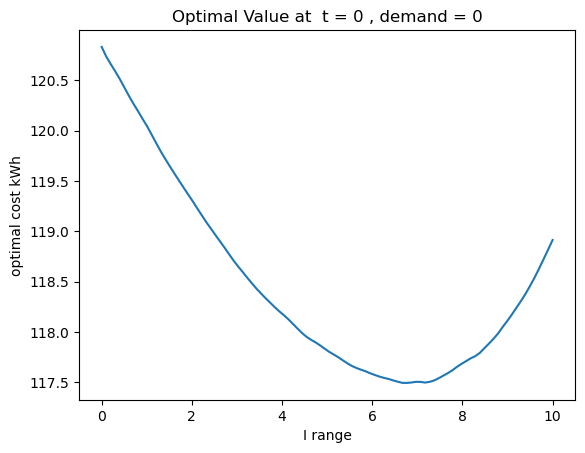

In [198]:
demand = 0 
I_range = torch.linspace(0,10,100)
cost_I = torch.zeros(len(I_range))
noise = torch.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
for i in range(len(I_range)):

    cost_I[i] = optimal_V(I_range[i],demand,noise)
import matplotlib.pyplot as plt

plt.plot(I_range.detach().numpy(), cost_I.detach().numpy())
plt.title("Optimal Value at  t = 0 , demand = 0")
plt.xlabel("I range")
plt.ylabel("optimal cost kWh")
plt.plot()


[]

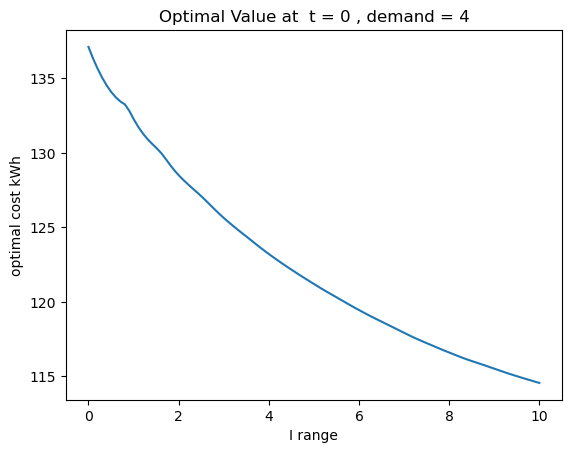

In [199]:
demand = 4
I_range = torch.linspace(0,10,100)
cost_I = torch.zeros(len(I_range))
noise = torch.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
for i in range(len(I_range)):

    cost_I[i] = optimal_V(I_range[i],demand,noise)
import matplotlib.pyplot as plt

plt.plot(I_range.detach().numpy(), cost_I.detach().numpy())
plt.title("Optimal Value at  t = 0 , demand = 4")
plt.xlabel("I range")
plt.ylabel("optimal cost kWh")
plt.plot()

If there is positive demand, cost is minimized the most when fully charged.

[]

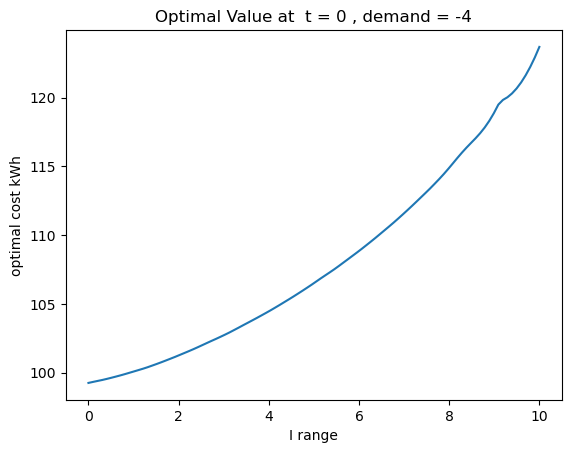

In [97]:
demand = -4
I_range = torch.linspace(0,10,100)
cost_I = torch.zeros(len(I_range))
noise = torch.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
for i in range(len(I_range)):

    cost_I[i] = optimal_V(I_range[i],demand,noise)
import matplotlib.pyplot as plt

plt.plot(I_range.detach().numpy(), cost_I.detach().numpy())
plt.title("Optimal Value at  t = 0 , demand = -4")
plt.xlabel("I range")
plt.ylabel("optimal cost kWh")
plt.plot()

If there is negative demand, cost is minimized the most when fully discharged.

[]

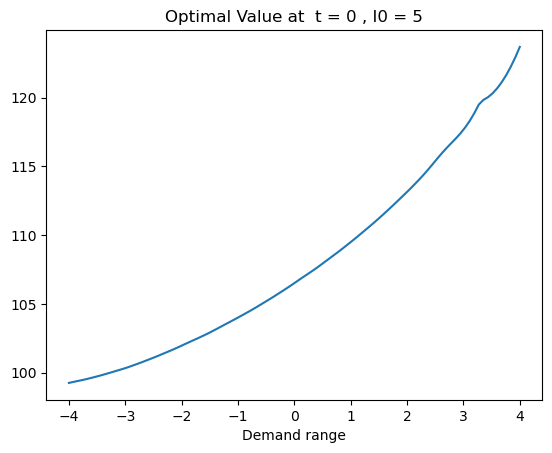

In [99]:
demand = torch.linspace(-4,4,100)
I_range =5
cost_demand = torch.zeros(len(demand))
noise = torch.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
for i in range(len(demand)):
    cost_demand[i] = optimal_V(I_range,demand[i],noise)
import matplotlib.pyplot as plt

plt.plot(demand.detach().numpy(), cost_I.detach().numpy())
plt.title("Optimal Value at  t = 0 , I0 = 5")
plt.xlabel("Demand range")
plt.plot()



[]

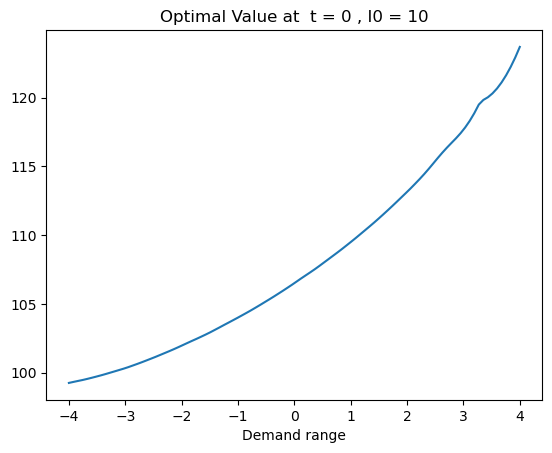

In [102]:
demand = torch.linspace(-4,4,100)
I_range =10
cost_demand = torch.zeros(len(demand))
noise = torch.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
for i in range(len(demand)):
    cost_demand[i] = optimal_V(10,demand[i],noise)
import matplotlib.pyplot as plt

plt.plot(demand.detach().numpy(), cost_I.detach().numpy())
plt.title("Optimal Value at  t = 0 , I0 = 10")
plt.xlabel("Demand range")
plt.plot()

[]

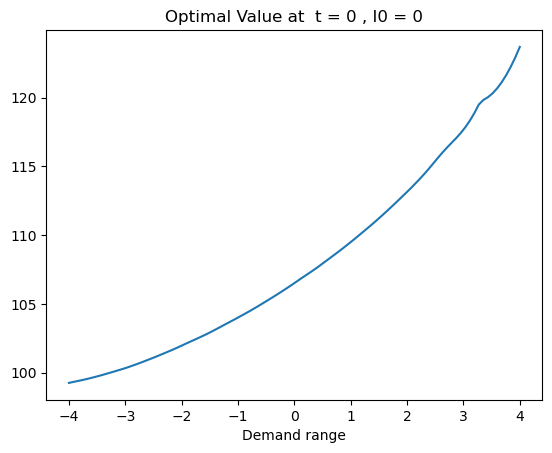

In [103]:
demand = torch.linspace(-4,4,100)
I_range =0
cost_demand = torch.zeros(len(demand))
noise = torch.normal(0,1,size = (1000,nstep) ) * np.sqrt(dt)
for i in range(len(demand)):
    cost_demand[i] = optimal_V(I_range,demand[i],noise)
import matplotlib.pyplot as plt

plt.plot(demand.detach().numpy(), cost_I.detach().numpy())
plt.title("Optimal Value at  t = 0 , I0 = 0")
plt.xlabel("Demand range")
plt.plot()

##  Value as a function of demand is same regardless of I. 

[]

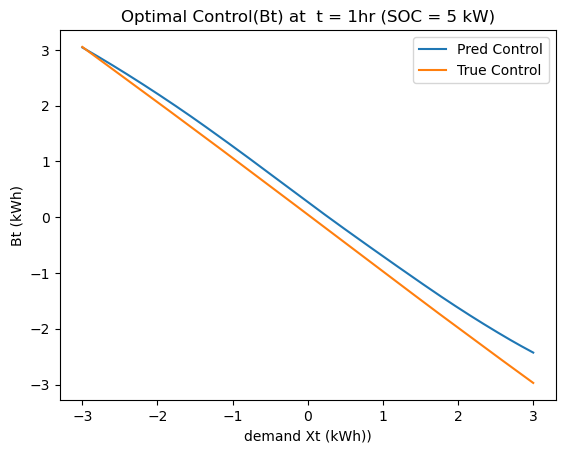

In [58]:
train_x = torch.linspace(-3,3,1000)
train_i = torch.ones(1000)*5
train = torch.column_stack((train_x,train_i))
train = train.requires_grad_(True)
# Optimal control according to NN
pred_control =trained_policy[95](train)
# finding optimal control according to PDE of HJB
v_i = torch.squeeze(torch.autograd.grad(pred_control.sum(),train,create_graph = True)[0])[:,1]
ub = torch.minimum(B_max*torch.ones(len(train[:,1])), (I_max-train[:,1])/dt)
lb = torch.maximum(B_min*torch.ones(len(train[:,1])), (-train[:,1])/dt)
# true control with hard bounds
true_control = -v_i/2 -train_x
true_control = torch.minimum(true_control,ub)
true_control = torch.maximum(true_control,lb)

# plotting optimal controsl
plt.plot(train_x.detach().numpy(), pred_control.detach().numpy())
plt.plot(train_x.detach().numpy(), true_control.detach().numpy())
plt.title("Optimal Control(Bt) at  t = 1hr (SOC = 5 kW)")
plt.xlabel("demand Xt (kWh))")
plt.ylabel("Bt (kWh)")
plt.legend(["Pred Control", "True Control"])
plt.plot()


[]

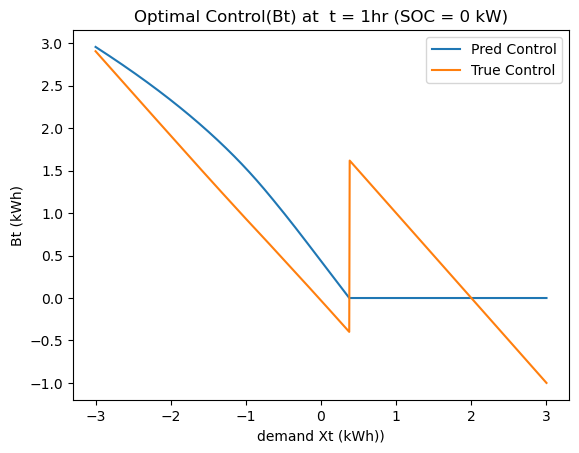

In [110]:
train_x = torch.linspace(-3,3,1000)
train_i = torch.ones(1000)*0
train = torch.column_stack((train_x,train_i))
train = train.requires_grad_(True)
# Optimal control according to NN
pred_control =trained_policy[95](train)
# finding optimal control according to PDE of HJB
v_i = torch.squeeze(torch.autograd.grad(pred_control.sum(),train,create_graph = True)[0])[:,1]
ub = torch.minimum(B_max*torch.ones(len(train[:,1])), (I_max-train[:,1])/dt)
lb = torch.maximum(B_min*torch.ones(len(train[:,1])), (-train[:,1])/dt)
# true control with hard bounds
true_control = -v_i/2 -train_x
#true_control = torch.minimum(true_control,ub)
#true_control = torch.maximum(true_control,lb)

# plotting optimal controsl
plt.plot(train_x.detach().numpy(), pred_control.detach().numpy())
plt.plot(train_x.detach().numpy(), true_control.detach().numpy())
plt.title("Optimal Control(Bt) at  t = 1hr (SOC = 0 kW)")
plt.xlabel("demand Xt (kWh))")
plt.ylabel("Bt (kWh)")
plt.legend(["Pred Control", "True Control"])
plt.plot()

[]

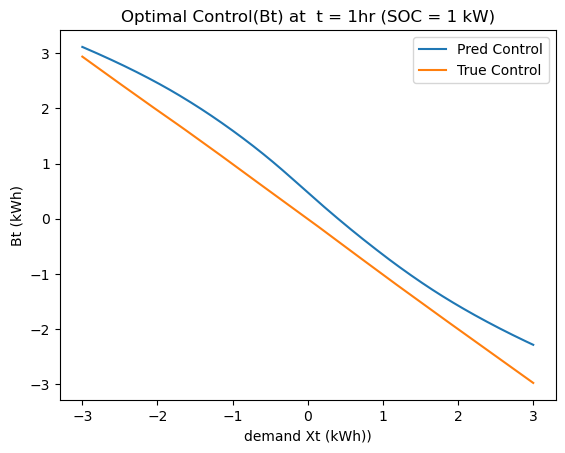

In [112]:
train_x = torch.linspace(-3,3,1000)
train_i = torch.ones(1000)*1
train = torch.column_stack((train_x,train_i))
train = train.requires_grad_(True)
# Optimal control according to NN
pred_control =trained_policy[95](train)
# finding optimal control according to PDE of HJB
v_i = torch.squeeze(torch.autograd.grad(pred_control.sum(),train,create_graph = True)[0])[:,1]
ub = torch.minimum(B_max*torch.ones(len(train[:,1])), (I_max-train[:,1])/dt)
lb = torch.maximum(B_min*torch.ones(len(train[:,1])), (-train[:,1])/dt)
# true control with hard bounds
true_control = -v_i/2 -train_x
true_control = torch.minimum(true_control,ub)
true_control = torch.maximum(true_control,lb)

# plotting optimal controsl
plt.plot(train_x.detach().numpy(), pred_control.detach().numpy())
plt.plot(train_x.detach().numpy(), true_control.detach().numpy())
plt.title("Optimal Control(Bt) at  t = 1hr (SOC = 1 kW)")
plt.xlabel("demand Xt (kWh))")
plt.ylabel("Bt (kWh)")
plt.legend(["Pred Control", "True Control"])
plt.plot()

In [105]:
def optimal_V(I0,X0,BM):
    Xs = torch.squeeze(demandSimulate(alpha, m0, sigma, nstep,1000, maturity,X0,True,BM))
    Is = torch.zeros((1000,nstep+1))
    Is[:,0] = I0
    running_cost = torch.zeros((1000,nstep))
    Bts = torch.zeros((1000,nstep))
    imbalance = torch.zeros(1000,nstep)
    for i in range(nstep):
        train = torch.column_stack((Xs[:,i],Is[:,i]))
        Bts[:,i] = trained_policy[i](train)
        Is[:,i+1] = Is[:,i]+Bts[:,i]*dt
        imbalance[:,i] = Bts[:,i] +Xs[:,i]
        running_cost[:,i] = f(Xs[:,i],Is[:,i],Bts[:,i])
    total_running_cost = torch.sum(running_cost,axis = 1)
    total_cost = torch.mean(total_running_cost+g(Is[:,-1]))

    return Xs,Is,Bts,imbalance


In [106]:
Xs,Is,Bts,imbalance = optimal_V(5,0,noise)

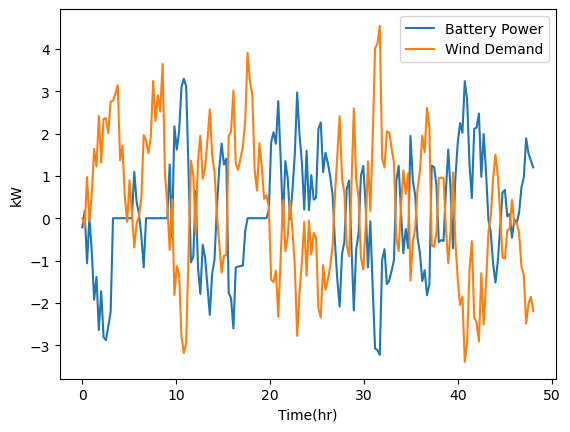

In [107]:
import matplotlib.pyplot as plt
t = np.linspace(0,48,192)
plt.plot(t,Bts[9,:].detach().numpy())
plt.plot(t,Xs[9,:-1].detach().numpy())
plt.xlabel("Time(hr)")
plt.ylabel("kW")
plt.legend(["Battery Power","Wind Demand" ])

[]

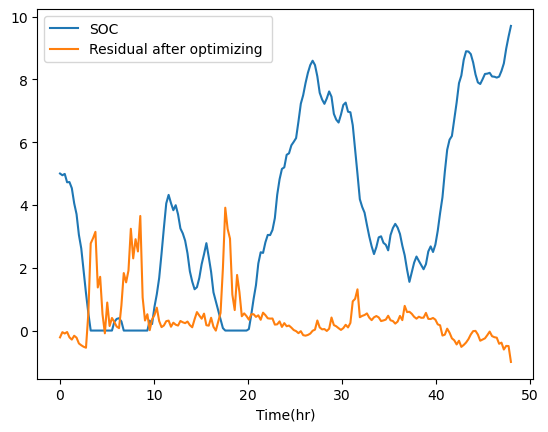

In [108]:
plt.plot(t,Is[9,:-1].detach().numpy())
plt.plot(t,imbalance[9,:].detach().numpy())
plt.xlabel("Time(hr)")

plt.legend(["SOC","Residual after optimizing " ])
plt.plot()

Plot v as function of x and i. B* as a function of x and i.

NN is not pointwise. GP is pointwise.

If no optimal hamitonian, how do we check optimal control is good? If exists, we can do comparison above. Else, problem!

Yuri saporito version of Deep Galerkin method paper

3 ways: solve directly then solve pde.  solve b_start then solve V. Third, solve b* as a function of implicit function of v and use that as loss.

Homework: Solve b star, then solve pde.